In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.metrics import accuracy_score

In [2]:
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

In [3]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
fake['target'] = 'fake'
true['target'] = 'true'

In [6]:
data = pd.concat([fake, true]).reset_index(drop = True)

In [7]:
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [8]:
data.drop(["date"],axis=1,inplace=True)
data.drop(["title"],axis=1,inplace=True)
data['text'] = data['text'].apply(lambda x: x.lower())

In [9]:
import string
def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str
data['text'] = data['text'].apply(punctuation_removal)

In [10]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kaart\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


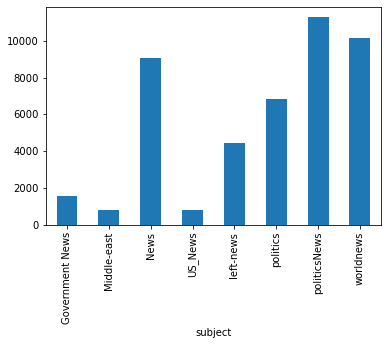

In [11]:
import matplotlib.pyplot as plt
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

In [12]:
from nltk import tokenize
import seaborn as sns
token_space = tokenize.WhitespaceTokenizer()
def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

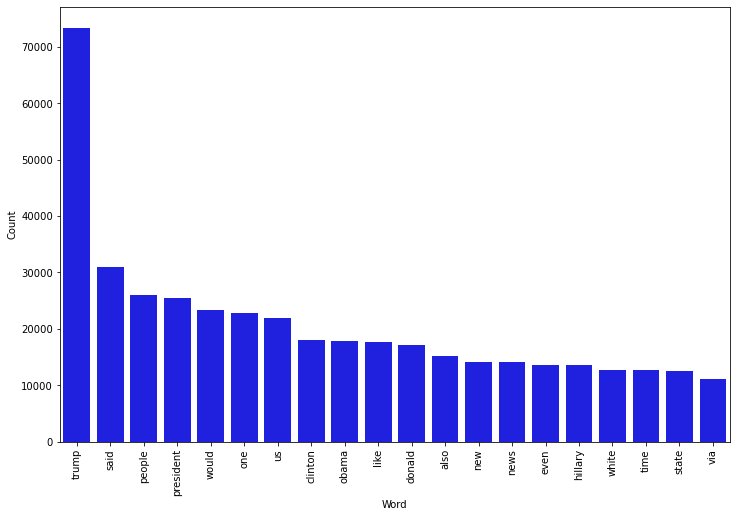

In [13]:
counter(data[data["target"] == "fake"], "text", 20)

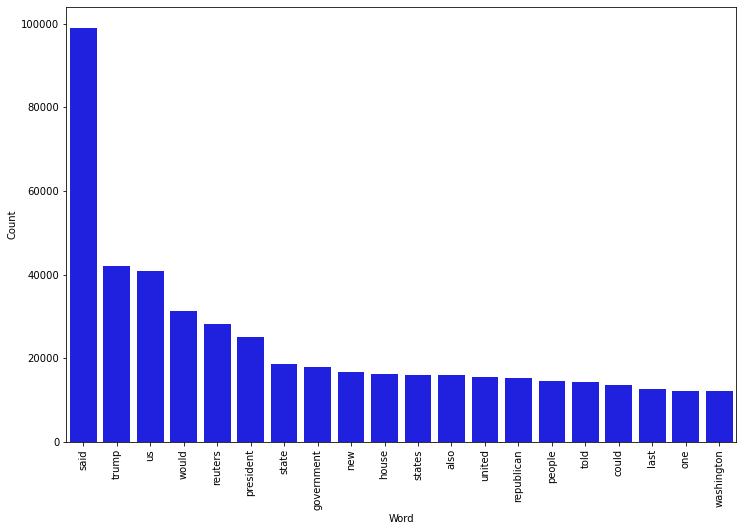

In [14]:
counter(data[data["target"] == "true"], "text", 20)

In [15]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

# Logistic Regression

In [16]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression
pipelr = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])
# Fitting the model
model_lr = pipelr.fit(X_train, y_train)
# Accuracy
prediction = model_lr.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.06%


# Decision Tree

In [17]:
from sklearn.tree import DecisionTreeClassifier
# Vectorizing and applying TF-IDF
pipedt = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model_dt = pipedt.fit(X_train, y_train)
# Accuracy
prediction = model_dt.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.57%


In [18]:
def output_label(n):
    if n == 0:
        return "Fake News"
    elif n == 1:
        return "Not A Fake News"
    
def manual_testing(news):
    testing_news = {"text":[news]}
    new_def_test = pd.DataFrame(testing_news)

    new_def_test["text"] = new_def_test["text"].apply(lambda x: x.lower())
    new_def_test["text"] = new_def_test["text"].apply(punctuation_removal)
    new_def_test["text"] = new_def_test["text"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    
    new_x_test = new_def_test["text"]
    new_xv_test = TfidfTransformer().transform(new_x_test)
    pred_LR = model_lr.predict(new_xv_test)
    pred_DT = model_dt.predict(new_xv_test)

    return print("\n\nLR Prediction: {} \nDT Prediction: {} ".format(output_lable(pred_LR[0]), 
                                                                    output_lable(pred_DT[0])))

In [19]:
news = str(pd.read_csv("y.csv"))
news

'  title                            text target\n0    hi  I am Karthik I live in Chennai   true\n1   bye                   I am not here   fake'

In [20]:
manual_testing(news)

ValueError: could not convert string to float: 'title text target 0 hi karthik live chennai true 1 bye fake'